<a href="https://colab.research.google.com/github/NafizIR/Gcollab/blob/I-comse/Friday/Day5_VAE_example1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Variational Autoencoder (VAE) for discrete data

This notebook introduces a simple VAE built in PyTorch using a toy dataset of one-hot encoded vectors generated from a two-component Gaussian mixture. The goal is to demonstrate how a VAE learns a low-dimensional latent space that captures the structure of the data, and how it can reconstruct inputs and generate new samples by sampling from the learned latent distribution.

The content modified from code given in the "Variational Autoencoder" section of "Deep Learning for Molecules and Materials\" textbook (https://dmol.pub/dl/VAE.html)
White, A. D. (2022). Deep learning for molecules and materials. Living journal of computational molecular science, 3(1).


---

Our first example will be to generate new example classes from a distribution of possible classes. The features are classes; we *are not* trying to make a classifier that takes in features and outputs classes. VAEs are for unlabeled data.

- **Q: Can you think of any other applications for using a VAE with discrete data?**





---

####**Task overview:**
- Features: $x$, represented as one-hot vectors corresponding to a class
- Goal: Learn the distribution $P(x)$ so that we can sample new $x$'s
 - **Q: Along with being able to sample new points, what else can we do after learning the latent space?**
   - Learning the latent space can also provide a way to embed your features into low dimensional continuous vectors, allowing you to do things like optimization because you've moved from discrete classes to continuous vectors

---


####**Implementing the Encoder and Decoder:**
- **Q: What are the inputs & outputs for the encoder?**
 - The encoder $q_\phi(z | x)$ should output a *probability distribution* for vectors of real numbers $z$ and take an input of a one-hot vector $x$
 - **Q: How can we have the encoder output a probability distribution? Is there a simpler way to do this?**
   - We defined $P(z)$ to be normally distributed, let's assume that the form of $q_\phi(z | x)$ should be normal. Then our NN could output the parameters to a normal distribution (mean/variance) for $z$, rather than trying to output a probability at every possible $z$ value. It's up to you if you want to have $q_\phi(z | x)$ output a D-dimensional Gaussian distribution with a covariance matrix or just output D independent normal distributions. Having $q_\phi(z | x)$ output a normal distribution also allows us to analytically simplify the expectation/integral in the KL-divergence term.

- **Q: What are the inputs & outputs for the decoder?**
  - The decoder $p_\theta(x | z)$ should output a probability distribution over classes given the input, a real vector $z$.
   - We can use the same form we use for classification: softmax activation. Just remember that we're not trying to output a specific $x$, just a probability distribution of $x$'s.
   - Softmax is similar to the sigmoid function, but is used when there are multiple classes

- **Q: What parameters do we have control over/can change for the VAE?**
  - The hyperparameters of the encoder and decoder and the size of $z$. It makes sense to have the encoder and decoder share as many hyperparameters as possible, since they're somewhat symmetric. Just remember that the encoder in our example is outputting a mean and variance (continuous values), which means using regression, and the decoder is outputting a normalized probability vector, which means using softmax. Let's get started!

In [ ]:
import torch
import torch.nn.functional as F
from torch import nn, optim
import numpy as np
import matplotlib.pyplot as plt
torch.manual_seed(0)

device = "cuda" if torch.cuda.is_available() else "cpu"

### The Data
The data is 1024 points $\vec{x}_i$ where each $\vec{x}_i$ is a 32 dimensional one-hot vector indicating class. We won't define the classes -- the data is synthetic. Since a VAE is unsupervised learning, there are no labels. Let's start by examining the data. We'll sum the occurrences of each class to see what the distribution of classes looks like.

e.g. [0, 0, 0, 1, 0, ..., 0]  ← means class index 3

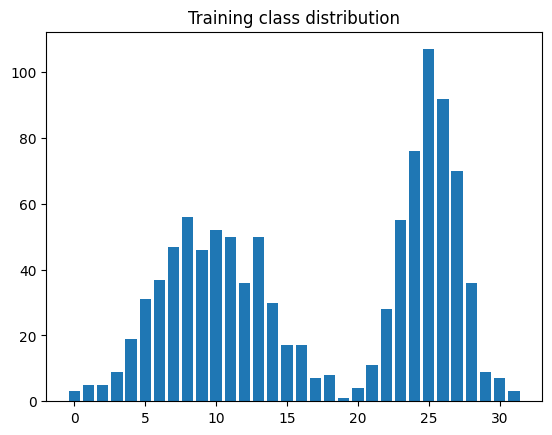

In [ ]:
# ------------------------------------------------------------
# Generate Synthetic one-hot categorical data
# ------------------------------------------------------------

n_samples    = 1_024         # Number of samples (rows) we want in our dataset
n_classes    = 32            # Each sample will belong to one of 32 categories
latent_dim   = 1             # We want the VAE to learn a 1D latent space
hidden_dim   = 16            # Size of the hidden layer in the neural network (not used yet here)

# Two-component Gaussian mixture, then histogram-bin to one-hot
z_true          = np.random.choice([0, 1], size=n_samples) # this is so we get two blobs in the distribution
x_continuous    = ((z_true + 1) % 2) * np.random.normal(-1, 0.5, n_samples) \
                  +  z_true            * np.random.normal(+1, 0.25, n_samples)

# gets edges of bins so that we can pass in the set and get what index bin it falls to
bins            = np.histogram_bin_edges(x_continuous, bins=n_classes)

# figures out which bin each datapoint falls into, returns index of that bin, in form of one-hot encoding
digitized_values = np.digitize(x_continuous, bins) - 1
digitized_values = np.clip(digitized_values, 0, n_classes - 1)
one_hot = np.eye(n_classes)[digitized_values]
data = torch.tensor(one_hot, dtype=torch.float32).to(device) # np array to pytorch tensor object, [1024, 32]

plt.bar(np.arange(n_classes), one_hot.sum(0))
plt.title("Training class distribution"); plt.show()

### The Encoder & Decoder

Our encoder will be a basic two hidden layer network.

We will output a $D\times2$ matrix, where the first column is means and the second is standard deviations for independent normal distributions that make up our guess for $q(z | x)$. Outputting a mean is simple, just use no activation. Outputting a standard deviation is unusual because they should be on $(0, \infty)$. `F.softplus` can accomplish this.

The decoder should output a vector of probabilities for $\vec{x}$. This can be achieved by just adding a softmax to the output. The rest is nearly identical to the encoder.



In [ ]:
# ------------------------------------------------------------
# Encoder & decoder
# ------------------------------------------------------------

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_classes, hidden_dim), nn.ReLU(), # input is 32D one hot
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, latent_dim * 2) # 2 bc μ and σ̂
        )

    # x is passed through network
    def forward(self, x):
        out         = self.net(x) # this is the NN defined in __init__
        mu, log_sig = out[:, :latent_dim], out[:, latent_dim:] # output shape is [batch_size,2]
        # softplus (kinda like reLU, but smoothed) to keep σ > 0
        sigma       = F.softplus(log_sig)
        return mu, sigma


# takes latent vector z (sampled from gaussian defined by encoder) and reconstructs input (a one-hot vector of 32 classes)
# given z, how likely is each of the 32 classes
class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(latent_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, n_classes) # logits → softmax later
        )

    # Logits are the raw scores output by a model before turning them into probabilities. [batch_size,32]
    # each number is a score for a class, which is then passed through a softmax function for a probability distribution
    def forward(self, z, return_logits=False):
        logits = self.net(z)
        if return_logits:
            return logits
        return F.softmax(logits, dim=-1)


### Training

We use ELBO equation for training:

$$
l = -\textrm{E}_{z \sim q_\phi(z | x_i)}\left[\log p_{\theta}(x_i | z)\right] + \beta*\textrm{KL}\left[(q_\phi(z | x))|| P(z)\right]
$$

where $P(z)$ is the standard normal distribution and we approximate expectations using a single sample from the encoder. We need to expand the KL-divergence term to implement this. Both $P(z)$ and $q_\theta(z | x)$ are normal. You can look-up the **KL-divergence** between two normal distributions:

\begin{equation}
KL(q, p) = \log \frac{\sigma_p}{\sigma_q} + \frac{\sigma_q^2 + (\mu_q - \mu_p)^2}{2 \sigma_p^2} - \frac{1}{2}
\end{equation}

we can simplify because $P(z)$ is standard normal ($\sigma = 1, \mu = 0$)

\begin{equation}
\textrm{KL}\left[(q_\theta(z | x_i))|| P(z)\right] = -\log \sigma_i + \frac{\sigma_i^2}{2} + \frac{\mu_i^2}{2} - \frac{1}{2}
\end{equation}

where $\mu_i, \sigma_i$ are the output from $q_\phi(z | x_i)$.

For a latent space dimension of 3, $x_i$ has the shape (1,n_classes), $\sigma_i$ has the shape (1,3), and $\mu_i$ has the shape (1,3).

The **reconstruction loss** depends on the type of input. For continuous data, usually Mean Squared Error (MSE) or L2 loss is used. For discrete data (as in this example), cross-entropy loss is often used - this compares the one-hot true class with the predicted probability distribution from the encoder.

---

**"Reparameterization trick"**

When training a VAE, we compute a loss that depends on a random sample from a distribution:
\begin{equation}
z \sim q_\phi(z | x) = \mathcal{N}(\mu(x), \sigma^2(x))
\end{equation}

But sampling from a distribution is not differentiable — and PyTorch (and other autodiff tools) can't compute gradients through the torch.randn() operation. That breaks backpropagation, which is how neural networks learn.

Instead of sampling from

\begin{equation}
z \sim \mathcal{N}(\mu, \sigma^2)
\end{equation}

we can rewrite it like this:

\begin{equation}
z = \mu + \sigma \cdot \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, 1)
\end{equation}

This is the same distribution, but μ and σ are outputs of the encoder. And ε is sampled independently from a fixed distribution (standard normal), so it's treated as a constant during gradient computation.

Now, $z$ becomes a differentiable function of μ and σ. That means gradients can flow back through and update the encoder's weights.


In [ ]:
# ------------------------------------------------------------
# Loss function
# ------------------------------------------------------------

# instantiate encoder and decoder NNs
encoder, decoder = Encoder().to(device), Decoder().to(device)

# combined parameters for both models to one list, single optimizer that updates
opt              = optim.Adam(list(encoder.parameters()) +
                              list(decoder.parameters()), lr=1e-1)

# loss for reconstruction and KL divergence
def vae_loss(x, beta=1.0):

    mu, sigma = encoder(x)

    # re-parameterisation trick - this makes the process differentiable
    eps       = torch.randn_like(mu)
    z_sample  = mu + eps * sigma

    # Get decoder outputs (logits)
    logits = decoder(z_sample, return_logits=True)

    # Convert one-hot back to class labels
    labels = x.argmax(dim=1)

    # reconstruction loss - cross entropy (per sample), recon_ll is negative log likelihood
    # measures how well decoder reconstructs x
    recon_ll = F.cross_entropy(logits, labels, reduction='none')

    # KL loss
    kl = -torch.log(sigma) + 0.5 * (sigma**2 + mu**2) - 0.5
    kl = kl.sum(dim=1)

    # beta to control balance of reconstruction vs KL
    total_loss = recon_ll + beta * kl

    return total_loss.mean(), recon_ll.mean(), kl.mean()

# ------------------------------------------------------------
# Training
# ------------------------------------------------------------

loss_traj, recon_traj, kl_traj = [], [], []

batch_size = 32
epochs = 16

for epoch in range(epochs):

    # randomly shuffle the dataset at the start of each epoch (prevents model from memorizing order of the data)
    perm = torch.randperm(len(data))

    for i in range(0, len(data), batch_size):
        batch = data[perm[i:i+batch_size]]

        opt.zero_grad() # clear any residual gradient from previous step
        loss, recon, kl = vae_loss(batch, beta=1) #
        loss.backward() # backprop
        opt.step() # optimizer step, update weights

        # saving loss for of the two parts and total
        loss_traj.append(loss.item())
        recon_traj.append(recon.item())
        kl_traj.append(kl.item())



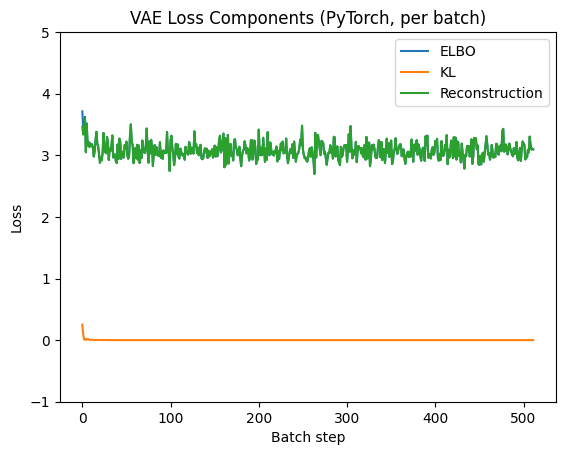

In [ ]:
# plot loss (ELBO)
elbo = np.array(recon_traj) + np.array(kl_traj)

plt.plot(elbo, label="ELBO")
plt.plot(kl_traj, label="KL")
plt.plot(recon_traj, label="Reconstruction")


plt.xlabel("Batch step")
plt.ylabel("Loss")
plt.legend()
plt.ylim(-1, 5)
plt.title("VAE Loss Components (PyTorch, per batch)")
plt.show()


### Evaluating the VAE

Remember our goal with the VAE is to reproduce $P(x)$. We can sample from our VAE using the chosen $P(z)$ and our decoder. Let's compare that distribution with our training distribution.


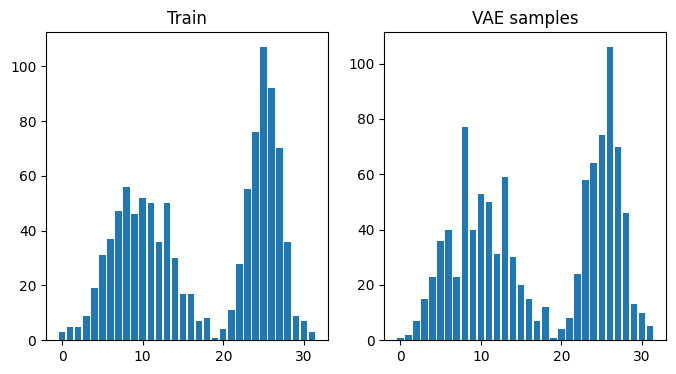

Average μ : 1.8486834960640408e-05 Average σ : 1.0000085830688477


In [ ]:
# Evaluate the trained VAE - generate 1024 new samples/fake data points

@torch.no_grad() # tells pytorch to not track gradients (we're not training, just sampling)
def sample_vae(n=1_024):
    z   = torch.randn(n, latent_dim, device=device) # sample z from standard normal distribution (if we knew something about the latent space, we could be more strategic in selecting here)
    px  = decoder(z) # pass z through decoder, return probability over 32 categories (softmax outputs) e.g. [0.01, 0.02...0.9..0.01]
    idx = torch.multinomial(px, num_samples=1).squeeze() # pick one class given the probabilities for each sample
    one_hot = F.one_hot(idx, n_classes).float() # turn class indice to one-hot vectors for easier plotting
    return one_hot.cpu().numpy()

samples = sample_vae()
fig, ax = plt.subplots(1,2, figsize=(8,4))
ax[0].bar(np.arange(n_classes), one_hot.sum(0)); ax[0].set_title("Train")
ax[1].bar(np.arange(n_classes), samples.sum(0));  ax[1].set_title("VAE samples")
plt.show()

# Encoder statistics  (should approach N(0,1))
mu, sigma = encoder(data)
print("Average μ :", mu.mean().item(),  "Average σ :", sigma.mean().item())


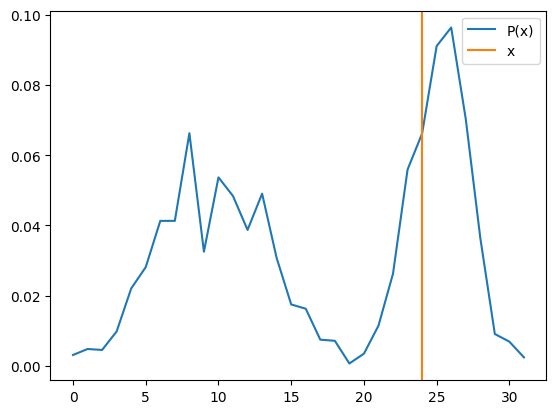

In [ ]:
# Quick reconstruction sanity-check

i   = 2 # chose random sample (this is the 3rd sample in set)
mu, sigma = encoder(data[i:i+1])
x_hat     = decoder(mu) # use mean of q(z|x) for clarity

plt.plot(x_hat.squeeze().cpu().detach().numpy(), label="P(x)") # plot predicted x as distribution
plt.axvline(data[i].argmax().cpu(), color='C1', label="x") # plot original x value as vertical line
plt.legend(); plt.show()


##Activity: How can we improve the reconstruction?